In [1]:
import warnings
warnings.filterwarnings('ignore')

# Matplotlib inline magic command
%matplotlib inline

In [2]:
# Initial imports
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
from collections import Counter
import psycopg2
from config import db_password
import json
from pandas.io.json import json_normalize
import mysql.connector
from sqlalchemy import create_engine
from os import walk
import time
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [3]:
# Scikit-Learn dependencies
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA

In [4]:
# Connect to AWS
def getDBengine1():
    user = 'postgres'
    passw = db_password
    host = 'policekillings.cv95lgysyvwq.us-east-1.rds.amazonaws.com'
    port = 5432
    database = 'PoliceKillings'
    engine_1 = create_engine(f'postgres+psycopg2://' + user + ':' + passw + '@' + host + ':' + str(port) + '/' + database ,  echo=False)
    return engine_1

In [5]:
# Load database into DataFrame
def getData1():
    s_statement = "select * from public.police_killings"
    # df = pd.read_sql(s_statement, con=getDBengine())
    try:
        df = pd.read_sql(s_statement, con=getDBengine1())
    except:
        print('failed')
    return df

In [6]:
killings_df = getData1()
killings_df.shape
print(killings_df.columns)

Index(['Victim_Age', 'Victim_Gender', 'Victim_Race', 'Date', 'City', 'State',
       'County', 'Responsible_Agency', 'Cause_of_death', 'Brief_Description ',
       'Criminal_Charges', 'Mental_Illness', 'Armed_Status', 'Threat_Level ',
       'Fleeing ', 'Body_Camera', 'Geography', 'Encounter_Type ',
       'Initial_Reason_for_Encounter ', 'Call_for_Service'],
      dtype='object')


In [7]:
# Load the data
file_path = 'Resources/2013-2020_Police_Killings_Revised.xlsx' 
killings_df = pd.read_excel(file_path)                         
killings_df

,Victim's age,Victim's gender,Victim's race,Date of Incident (month/day/year),County,Agency responsible for death,Cause of death,Symptoms of mental illness?,Armed/Unarmed Status,Alleged Threat Level (Source: WaPo),Fleeing (Source: WaPo),Body Camera (Source: WaPo),Geography,Encounter Type (DRAFT),Initial Reported Reason for Encounter (DRAFT),Call for Service? (DRAFT)
0,Unknown,Male,Unknown Race,2021-04-18,NaN,Detroit Police Department,Gunshot,NaN,Allegedly Armed,attack,NaN,NaN,NaN,Part 1 Violent Crime,shooting,NaN
1,Unknown,Male,Unknown Race,2021-04-18,NaN,Douglasville Police Department,Gunshot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Unknown,Male,Unknown Race,2021-04-18,NaN,Fort Worth Police Department,Gunshot,NaN,Allegedly Armed,NaN,NaN,NaN,NaN,Other Non-Violent Offense,carjacking,NaN
3,Unknown,Male,White,2021-04-18,NaN,Burnsville Police Department,Gunshot,NaN,Allegedly Armed,attack,car,NaN,NaN,Other Non-Violent Offense,carjacking,NaN
4,Unknown,Male,Black,2021-04-17,NaN,Winter Haven Police Department,Gunshot,NaN,NaN,NaN,NaN,NaN,NaN,Domestic disturbance,Domestic disturbance (armed),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9077,21,Male,White,2013-01-01,Douglas,Douglas County Sheriff's Office,Gunshot,Drug or alcohol use,Allegedly Armed,NaN,NaN,NaN,Rural,NaN,NaN,NaN
9078,26,Male,White,2013-01-01,Blue Earth,Mankato Department of Public Safety,Taser,No,Unarmed/Did Not Have Actual Weapon,NaN,NaN,NaN,Suburban,NaN,NaN,NaN
9079,21,Male,Hispanic,2013-01-01,Pueblo,Pueblo Police Department,Gunshot,No,Allegedly Armed,NaN,NaN,NaN,Suburban,NaN,NaN,NaN
9080,49,Male,Hispanic,2013-01-01,San Juan,Farmington Police Department,Gunshot,No,Allegedly Armed,NaN,NaN,NaN,Urban,NaN,NaN,NaN


In [8]:
# Rename columns
killings_df.rename(columns = {"Victim's age" : 'Victim_Age', "Victim's gender" : 'Victim_Gender', 
                              "Victim's race" : 'Victim_Race', 'Date of Incident (month/day/year)' : 'Date',
                              'Agency responsible for death' : 'Responsible_Agency', 'Cause of death' : 'Cause_of_Death',
                              'A brief description of the circumstances surrounding the death' : 'Brief_Description',
                              'Criminal Charges?' : 'Criminal_Charges', 'Symptoms of mental illness?' : 'Mental_Illness', 
                              'Armed/Unarmed Status' : 'Armed_Status', 'Alleged Threat Level (Source: WaPo)' : 'Threat_Level', 
                              'Fleeing (Source: WaPo)' : 'Fleeing', 'Body Camera (Source: WaPo)' : 'Body_Camera', 
                              'Encounter Type (DRAFT)' : 'Encounter_Type', 
                              'Initial Reported Reason for Encounter (DRAFT)' : 'Initial_Reason_for_Encounter',
                              'Call for Service? (DRAFT)' : 'Call_for_Service'}, inplace = True)

killings_df.head()

,Victim_Age,Victim_Gender,Victim_Race,Date,County,Responsible_Agency,Cause_of_Death,Mental_Illness,Armed_Status,Threat_Level,Fleeing,Body_Camera,Geography,Encounter_Type,Initial_Reason_for_Encounter,Call_for_Service
0,Unknown,Male,Unknown Race,2021-04-18,NaN,Detroit Police Department,Gunshot,NaN,Allegedly Armed,attack,NaN,NaN,NaN,Part 1 Violent Crime,shooting,NaN
1,Unknown,Male,Unknown Race,2021-04-18,NaN,Douglasville Police Department,Gunshot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Unknown,Male,Unknown Race,2021-04-18,NaN,Fort Worth Police Department,Gunshot,NaN,Allegedly Armed,NaN,NaN,NaN,NaN,Other Non-Violent Offense,carjacking,NaN
3,Unknown,Male,White,2021-04-18,NaN,Burnsville Police Department,Gunshot,NaN,Allegedly Armed,attack,car,NaN,NaN,Other Non-Violent Offense,carjacking,NaN
4,Unknown,Male,Black,2021-04-17,NaN,Winter Haven Police Department,Gunshot,NaN,NaN,NaN,NaN,NaN,NaN,Domestic disturbance,Domestic disturbance (armed),NaN


In [9]:
# Delete columns
del killings_df['Victim_Gender']
#del killings_df['City']
#del killings_df['State']
#del killings_df['Criminal_Charges']
#del killings_df['Brief_Description']

In [10]:
# Find null values
for column in killings_df.columns:
    print(f'Column {column} has {killings_df[column].isnull().sum()} null values')

Column Victim_Age has 8 null values
Column Victim_Race has 0 null values
Column Date has 0 null values
Column County has 26 null values
Column Responsible_Agency has 4 null values
Column Cause_of_Death has 0 null values
Column Mental_Illness has 69 null values
Column Armed_Status has 6 null values
Column Threat_Level has 2394 null values
Column Fleeing has 3077 null values
Column Body_Camera has 3147 null values
Column Geography has 31 null values
Column Encounter_Type has 4310 null values
Column Initial_Reason_for_Encounter has 4310 null values
Column Call_for_Service has 5539 null values


In [11]:
# Replace empty/blank values for Age, Threat_Level, Fleeing, Body_Camera, Encounter_Type, Initial_Reason_for_Encounter, 
# Call_for_Service and re-verify null values

# Column: Age
killings_df['Victim_Age'].replace({'Unknown': '0'}, inplace = True) 
                                                                    
# Column: Threat_Level
killings_df['Threat_Level'].replace({None: 'undetermined'}, inplace = True)

# Column: Fleeing
killings_df['Fleeing'].replace({None: 'unknown'}, inplace = True)

# Column: Body_Camera
killings_df['Body_Camera'].replace({None: 'unknown'}, inplace = True)

# Column: Encounter_Type
killings_df['Encounter_Type'].replace({None: 'Unknown'}, inplace = True)

# Column: Initial_Reason_for_Encounter
killings_df['Initial_Reason_for_Encounter'].replace({None: 'unknown'}, inplace = True)

# Column: Call_for_Service
killings_df['Call_for_Service'].replace({None: 'Unavailable'}, inplace = True)

# Verify null values
for column in killings_df.columns:
    print(f'Column {column} has {killings_df[column].isnull().sum()} null values')

Column Victim_Age has 8 null values
Column Victim_Race has 0 null values
Column Date has 0 null values
Column County has 26 null values
Column Responsible_Agency has 4 null values
Column Cause_of_Death has 0 null values
Column Mental_Illness has 69 null values
Column Armed_Status has 6 null values
Column Threat_Level has 0 null values
Column Fleeing has 0 null values
Column Body_Camera has 0 null values
Column Geography has 31 null values
Column Encounter_Type has 0 null values
Column Initial_Reason_for_Encounter has 0 null values
Column Call_for_Service has 0 null values


In [12]:
# Drop null values
killings_df = killings_df.dropna(how = 'any')
killings_df = killings_df.reset_index().drop(['index'], axis = 1)

In [13]:
# Inspect column data types
killings_df.dtypes

Victim_Age                              object
Victim_Race                             object
Date                            datetime64[ns]
County                                  object
Responsible_Agency                      object
Cause_of_Death                          object
Mental_Illness                          object
Armed_Status                            object
Threat_Level                            object
Fleeing                                 object
Body_Camera                             object
Geography                               object
Encounter_Type                          object
Initial_Reason_for_Encounter            object
Call_for_Service                        object
dtype: object

In [14]:
# Change Victim_Age data type from object to int
killings_df['Victim_Age'] = killings_df['Victim_Age'].astype(str).astype(int)
killings_df.dtypes

Victim_Age                               int32
Victim_Race                             object
Date                            datetime64[ns]
County                                  object
Responsible_Agency                      object
Cause_of_Death                          object
Mental_Illness                          object
Armed_Status                            object
Threat_Level                            object
Fleeing                                 object
Body_Camera                             object
Geography                               object
Encounter_Type                          object
Initial_Reason_for_Encounter            object
Call_for_Service                        object
dtype: object

In [15]:
# Extract year from Date and create new column Year
killings_df['Year'] = pd.DatetimeIndex(killings_df['Date']).year

# Extract month from Date and create new column Month
killings_df['Month'] = pd.DatetimeIndex(killings_df['Date']).month

# Extract day from Date and create new column Day
killings_df['Day'] = pd.DatetimeIndex(killings_df['Date']).day

In [16]:
# Get holiday from Date and create new column Holiday
dr = pd.date_range(start='2013-01-01', end='2021-04-18')
df = pd.DataFrame()
df['Date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

killings_df['Holiday'] = killings_df['Date'].dt.date.astype('datetime64').isin(holidays)

In [17]:
# Use get_dummies() to transform text values into numerical values
killings_encoded = pd.get_dummies(killings_df, columns = 
                                  ['Cause_of_Death', 'Mental_Illness', 'Armed_Status', 'Threat_Level', 'Fleeing', 
                                   'Body_Camera', 'Geography', 'County', 'Responsible_Agency', 'Encounter_Type', 
                                   'Initial_Reason_for_Encounter', 'Call_for_Service'])

killings_encoded.head()

,Victim_Age,Victim_Race,Date,Year,Month,Day,Holiday,Cause_of_Death_Asphyxiated,"Cause_of_Death_Baton, Pepper Spray, Physical Restraint",Cause_of_Death_Bean bag,...,"Initial_Reason_for_Encounter_wellness check/erratic behavior, other: danger to self (suicide)","Initial_Reason_for_Encounter_wellness check/erratic behavior, shooting/shots fired","Initial_Reason_for_Encounter_wellness check/erratic behavior, warrant (failure to appear)","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense (gun)",Call_for_Service_No,Call_for_Service_No,Call_for_Service_Unavailable,Call_for_Service_Yes,Call_for_Service_yes
0,46,Hispanic,2021-04-14,2021,4,14,False,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,48,Unknown Race,2021-04-10,2021,4,10,False,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,Unknown Race,2021-04-10,2021,4,10,False,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,Unknown Race,2021-04-10,2021,4,10,False,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,50,Unknown Race,2021-04-09,2021,4,9,False,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [18]:
# Drop Date column
killings_encoded = killings_encoded.drop(['Date'], axis = 1)

In [19]:
killings_encoded['Victim_Race'].value_counts()

White               3935
Black               2259
Hispanic            1565
Unknown Race         903
Asian                134
Native American      127
Pacific Islander      50
Hispanic               1
Name: Victim_Race, dtype: int64

In [20]:
killings_df[killings_df['Victim_Race'] == 'Hispanic ']

,Victim_Age,Victim_Race,Date,County,Responsible_Agency,Cause_of_Death,Mental_Illness,Armed_Status,Threat_Level,Fleeing,Body_Camera,Geography,Encounter_Type,Initial_Reason_for_Encounter,Call_for_Service,Year,Month,Day,Holiday
217,26,Hispanic,2021-01-27,Bexar,San Antonio Police Department,Gunshot,No,Allegedly Armed,other,foot,yes,Suburban,Traffic Stop,Traffic violation,No,2021,1,27,False


In [21]:
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Hispanic ', 'Hispanic')

In [22]:
killings_encoded[killings_encoded['Victim_Race'] != 'Hispanic ']

,Victim_Age,Victim_Race,Year,Month,Day,Holiday,Cause_of_Death_Asphyxiated,"Cause_of_Death_Baton, Pepper Spray, Physical Restraint",Cause_of_Death_Bean bag,Cause_of_Death_Beaten,...,"Initial_Reason_for_Encounter_wellness check/erratic behavior, other: danger to self (suicide)","Initial_Reason_for_Encounter_wellness check/erratic behavior, shooting/shots fired","Initial_Reason_for_Encounter_wellness check/erratic behavior, warrant (failure to appear)","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense (gun)",Call_for_Service_No,Call_for_Service_No,Call_for_Service_Unavailable,Call_for_Service_Yes,Call_for_Service_yes
0,46,Hispanic,2021,4,14,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,48,Unknown Race,2021,4,10,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,Unknown Race,2021,4,10,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,Unknown Race,2021,4,10,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,50,Unknown Race,2021,4,9,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,21,White,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8970,26,White,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8971,21,Hispanic,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8972,49,Hispanic,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [23]:
# Convert Victim_Race values to numbers
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('White', 1)
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Black', 2)
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Hispanic', 3)
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Unknown Race', 4)
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Asian', 5)
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Native American', 6)
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Pacific Islander', 7)

killings_encoded['Victim_Race']

0       3
1       4
2       4
3       4
4       4
       ..
8969    1
8970    1
8971    3
8972    3
8973    2
Name: Victim_Race, Length: 8974, dtype: int64

In [24]:
killings_encoded

,Victim_Age,Victim_Race,Year,Month,Day,Holiday,Cause_of_Death_Asphyxiated,"Cause_of_Death_Baton, Pepper Spray, Physical Restraint",Cause_of_Death_Bean bag,Cause_of_Death_Beaten,...,"Initial_Reason_for_Encounter_wellness check/erratic behavior, other: danger to self (suicide)","Initial_Reason_for_Encounter_wellness check/erratic behavior, shooting/shots fired","Initial_Reason_for_Encounter_wellness check/erratic behavior, warrant (failure to appear)","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense (gun)",Call_for_Service_No,Call_for_Service_No,Call_for_Service_Unavailable,Call_for_Service_Yes,Call_for_Service_yes
0,46,3,2021,4,14,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,48,4,2021,4,10,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,4,2021,4,10,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,4,2021,4,10,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,50,4,2021,4,9,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,21,1,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8970,26,1,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8971,21,3,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8972,49,3,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Split Data into Training and Testing Sets Using Principal Component Analysis

In [25]:
# Create features
X = pd.get_dummies(killings_encoded.drop(columns = ['Victim_Race']))

# Create target
y = pd.DataFrame(killings_encoded['Victim_Race'])

In [26]:
# View count of each class
y.value_counts()

Victim_Race
1              3935
2              2259
3              1566
4               903
5               134
6               127
7                50
dtype: int64

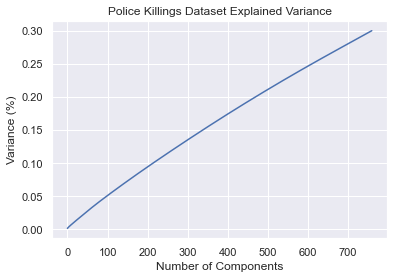

In [28]:
X_std = StandardScaler().fit_transform(killings_encoded)
pca = PCA(n_components=.3)

# Plot the explained variances
principalComponents = pca.fit_transform(X_std) 

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Police Killings Dataset Explained Variance')
plt.show()

In [29]:
pca = PCA(n_components=200)
principalComponents = pca.fit_transform(X_std)
pca_df = pd.DataFrame(principalComponents)

In [30]:
pca_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-2.053336,0.201003,6.480138,-0.690389,-0.907118,0.159582,-2.384872,-1.593151,0.965778,0.664231,...,0.522191,-0.091748,-0.140072,0.314865,0.155282,0.316005,-0.067589,-0.643856,-0.615962,0.797220
1,-3.556243,2.495833,2.477089,-1.786835,4.541145,0.091950,-3.546811,-0.016445,-0.946444,-0.045777,...,-0.218085,-0.697380,0.472200,-0.134094,0.277054,-0.235324,0.323903,-0.506479,0.413576,0.786122
2,-1.121591,4.403930,3.566486,-1.445717,0.009895,0.961543,-1.311142,-1.008688,1.758856,-0.485725,...,1.174857,0.672695,-1.107827,-1.525662,1.794319,0.621546,0.488848,1.326385,0.121607,1.197142
3,-2.515244,2.556796,2.236906,-1.211402,2.381837,-0.084699,-1.092050,-0.612350,-0.245558,-0.188962,...,-0.380025,-0.510109,-0.482793,-0.645072,0.438083,-1.178140,0.487149,1.407167,-1.438986,0.763010
4,-3.792440,4.029766,2.058504,-1.884357,3.010093,1.280798,-4.376320,-0.820516,0.852899,-0.014883,...,-0.598311,0.458219,-0.868621,0.783408,0.846632,0.433117,-0.566449,-0.847189,0.071134,0.670830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,3.762519,0.198422,0.257480,0.013439,0.604198,1.423162,0.086794,-0.389301,-0.015719,-0.011847,...,0.264438,0.859042,0.849626,-1.241883,1.736227,-0.552676,1.817161,-1.102148,0.812977,0.095390
8970,5.023758,2.240823,3.414908,-0.220839,-3.099748,-1.226049,0.955965,-0.067151,1.069051,-0.426307,...,0.110566,1.278385,-1.012913,2.784258,-0.297342,3.673072,0.058606,-0.266960,2.559894,-3.377966
8971,2.983182,1.163225,-0.500903,-0.301550,0.847986,-1.352742,0.768564,0.236036,1.013626,-0.296265,...,0.391921,0.533092,2.330224,0.140670,-0.740522,-0.043310,-0.065968,0.836341,-0.646107,-1.082581
8972,3.512126,1.308479,-0.641783,-0.630672,1.799494,-0.546507,0.401502,0.009520,-1.916073,-0.440718,...,-1.722007,-0.483891,0.061920,0.472589,0.500118,2.258478,-1.543517,0.853517,1.379348,-1.163644


In [31]:
# Train, test, and split model
X_train, X_test, y_train, y_test = train_test_split(pca_df,y, random_state = 1, stratify = y)
                                                                                                   
y_train.shape

(6730, 1)

## Random Forest Model

In [32]:
# Create a random forest classifier
rf_model = RandomForestClassifier()

In [33]:
# Fit the model
rf_model = rf_model.fit(X_train, y_train)

In [34]:
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

In [35]:
# Prediction
rf_y_pred = rf_model.predict(X_test)
rf_y_pred

array([1, 2, 1, ..., 1, 1, 1], dtype=int64)

In [36]:
# Calculate ROC accuracy score
multiclass_roc_auc_score(y_test, rf_y_pred)

0.6101761432922771

In [37]:
# Print classification report
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           1       0.59      0.88      0.70       984
           2       0.54      0.44      0.48       565
           3       0.57      0.39      0.46       392
           4       0.33      0.04      0.08       226
           5       0.33      0.03      0.06        33
           6       0.33      0.03      0.06        32
           7       0.83      0.42      0.56        12

    accuracy                           0.57      2244
   macro avg       0.50      0.32      0.34      2244
weighted avg       0.54      0.57      0.52      2244



In [38]:
# Display the confusion matrix
rf_cm = confusion_matrix(y_test, rf_y_pred)
rf_cm

array([[864,  83,  33,   3,   0,   1,   0],
       [266, 248,  43,   7,   1,   0,   0],
       [156,  76, 152,   7,   1,   0,   0],
       [148,  36,  30,  10,   0,   1,   1],
       [ 10,  13,   8,   1,   1,   0,   0],
       [ 23,   5,   2,   1,   0,   1,   0],
       [  5,   0,   1,   1,   0,   0,   5]], dtype=int64)

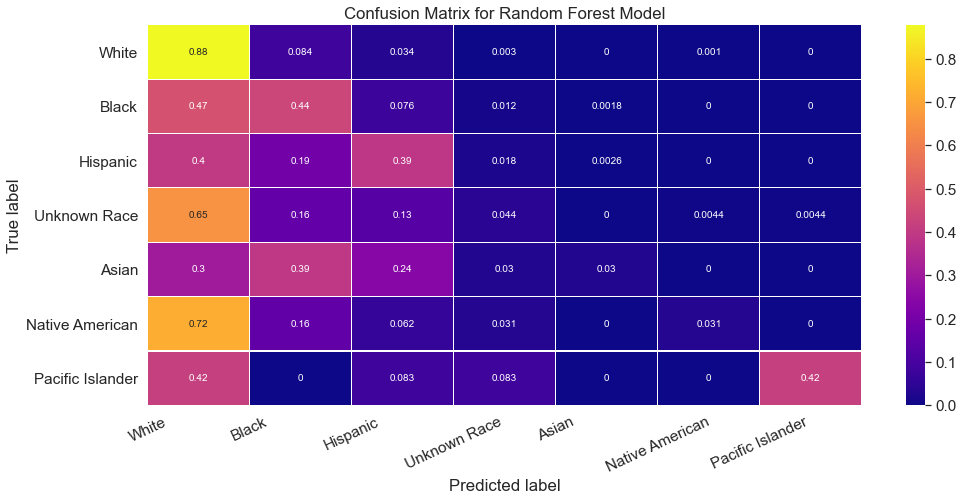

In [39]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, rf_y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.plasma, linewidths=0.2)

# Add labels to the plot
class_names = ['White', 'Black', 'Hispanic', 'Unknown Race', 'Asian', 'Native American', 'Pacific Islander']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

## Attempt to Optimize Random Forest Model

In [40]:
# Create the parameter grid
param_grid = {
    'max_depth': [10, 20, 50],
    'max_leaf_nodes': [10],
    'n_estimators': [100],
    #'oob_score': [True],
    #'random_state': [0],
    #'max_samples': [10, 20, 100],
    'max_features': [10],
    #'min_samples_split': [2, 10, 20]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                      cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

# Fit the grid search to the data
grid_search.fit(X_train, y_train);
grid_search.best_params_
best_grid = grid_search.best_estimator_
pprint(best_grid.get_params())
selector = RFE(rf_model, step=1, verbose=3)
selector = selector.fit(X_train, y_train)
print("Features sorted by their rank:")
pprint(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), X)))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 10,
 'max_leaf_nodes': 10,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 fe

In [41]:
# Extract feature importance
fi = pd.DataFrame({'feature': list(pca_df.columns),
                   'importance': rf_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi

,feature,importance
5,5,0.030910
3,3,0.015335
1,1,0.013196
14,14,0.009471
32,32,0.008929
...,...,...
43,43,0.003827
199,199,0.003808
127,127,0.003738
76,76,0.003734


## Re-Train Random Forest Model

In [42]:
# Re-create a random forest classifier
opt_rf_model = RandomForestClassifier()

In [43]:
# Re-fit the model
opt_rf_model = rf_model.fit(X_train, y_train)

In [44]:
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

In [45]:
# Re-calculate Balanced Accuracy Score
opt_rf_y_pred = opt_rf_model.predict(X_test)
opt_rf_y_pred

array([1, 2, 1, ..., 1, 1, 1], dtype=int64)

In [46]:
# Re-calculate ROC accuracy score
multiclass_roc_auc_score(y_test, opt_rf_y_pred)

0.6203090759483612

In [47]:
# Re-print classification report
print(classification_report(y_test, opt_rf_y_pred))

              precision    recall  f1-score   support

           1       0.59      0.86      0.70       984
           2       0.53      0.44      0.48       565
           3       0.53      0.40      0.46       392
           4       0.38      0.04      0.08       226
           5       1.00      0.03      0.06        33
           6       0.75      0.09      0.17        32
           7       0.75      0.50      0.60        12

    accuracy                           0.57      2244
   macro avg       0.65      0.34      0.36      2244
weighted avg       0.55      0.57      0.52      2244



In [48]:
# Display the confusion matrix with optimized model
opt_rf_cm = confusion_matrix(y_test, opt_rf_y_pred )
opt_rf_cm

array([[851,  91,  37,   5,   0,   0,   0],
       [265, 248,  46,   5,   0,   0,   1],
       [159,  74, 156,   3,   0,   0,   0],
       [136,  41,  37,  10,   0,   1,   1],
       [ 13,   8,  10,   1,   1,   0,   0],
       [ 19,   2,   6,   2,   0,   3,   0],
       [  5,   0,   1,   0,   0,   0,   6]], dtype=int64)

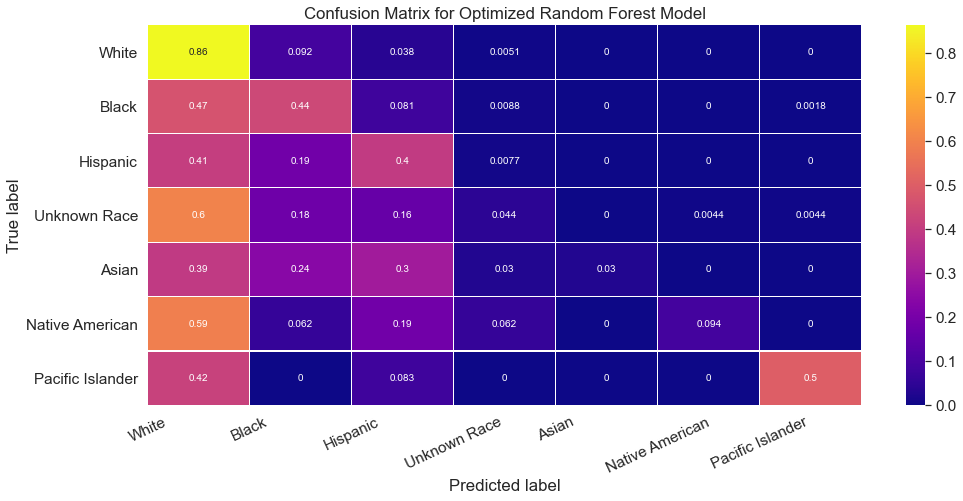

In [49]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, opt_rf_y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.plasma, linewidths=0.2)

# Add labels to the plot
class_names = ['White', 'Black', 'Hispanic', 'Unknown Race', 'Asian', 'Native American', 'Pacific Islander']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Optimized Random Forest Model')
plt.show()